## Plot RSAM G.RAUNG


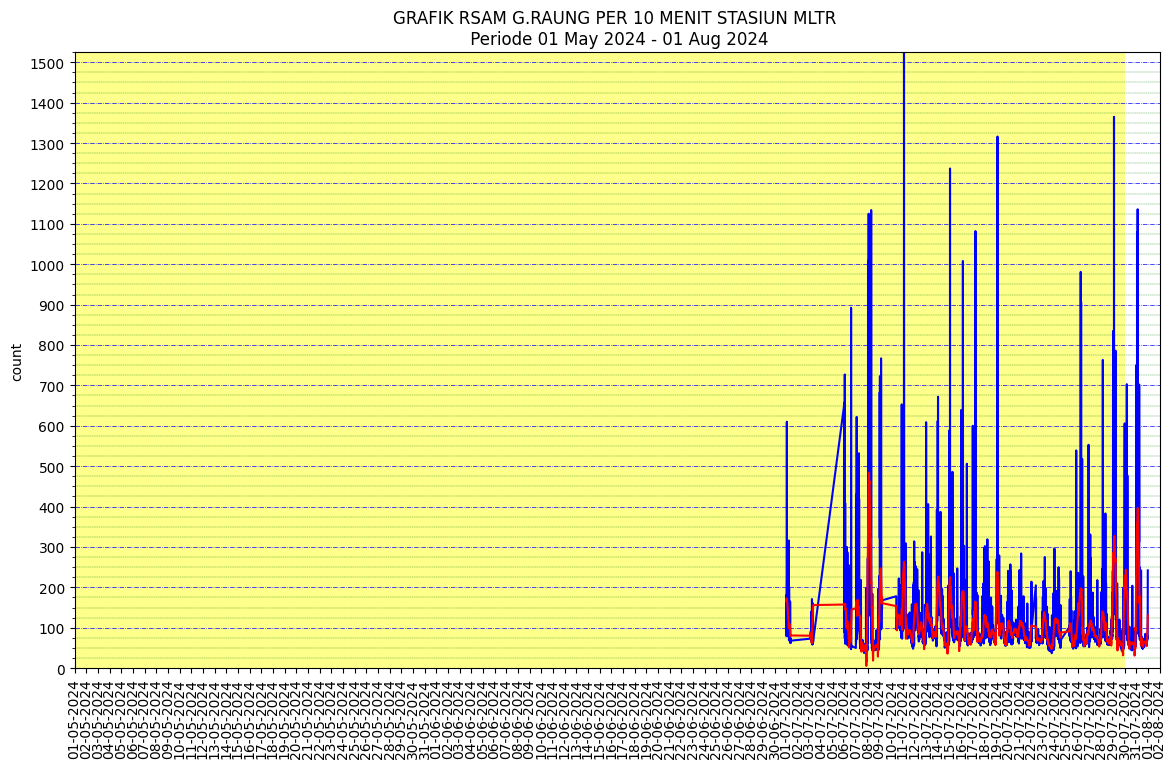

In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
from scipy.signal import savgol_filter

# Sesuaikan path file
nama_file = r'\\angsa\data\Rsam\10Minute\202407_VG_MLTN_EHZRSAM10Min.DAT'

# Masukkan parameter nama gunung, nama stasiun, waktu awal, waktu akhir, dan interval axis X
gunung = 'RAUNG'
stasiun = 'MLTR'

waktu_awal = '01-05-2024'
waktu_akhir = '01-08-2024'
interval_hari = 1

major_interval = 100
minor_interval = 25

data = pd.read_csv(nama_file, header=None, names=['Time', 'RSAM'])
data['Time'] = pd.to_datetime(data['Time'], format='%d-%b-%Y %H:%M:%S')

start_date = datetime.strptime(waktu_awal, '%d-%m-%Y')
end_date = datetime.strptime(waktu_akhir, '%d-%m-%Y')
end_date += timedelta(days=1)
data_bulan = data[(data['Time'] >= start_date) & (data['Time'] <= end_date)]

# Mengeplot data
plt.figure(figsize=(14, 8))
plt.plot(data_bulan['Time'], data_bulan['RSAM'], label='RSAM', marker='', linestyle='-', color='blue')

plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
plt.xticks(rotation=90)
plt.ylabel('count')

end_date -= timedelta(days=1)
formatted_start_date = start_date.strftime('%d %b %Y')
formatted_end_date = end_date.strftime('%d %b %Y')

plt.title(f'GRAFIK RSAM G.{gunung} PER 10 MENIT STASIUN {stasiun} \n Periode {formatted_start_date} - {formatted_end_date}')
end_date += timedelta(days=1)

# Savitzky-Golay smoothing
window_size = 50  # Panjang jendela smoothing
degree = 3        # Derajat polinomial
smoothed_data = savgol_filter(data_bulan['RSAM'], window_size, degree)
plt.plot(data_bulan['Time'], smoothed_data, linestyle='-', color='red')

# Nilai maksimum count pada data :
nilai_maksimal_data = int(max(data_bulan['RSAM'])) + 1

# Nilai maksimum count pada grafik bisa diubah di sini bila 'nilai_maksimum_custom' yang digunakan :
nilai_maksimum_custom = 1000

# Pilih nilai maksimum yang ingin digunakan 'nilai_maksimal_data' atau 'nilai_maksimum_custom'
nilai_maksimum = nilai_maksimal_data

plt.gca().set_ylim(0, nilai_maksimum)
plt.xlim(start_date, end_date)
plt.yticks(range(0, nilai_maksimum, major_interval))
plt.ylim(0)

plt.grid(which='major', axis='y', linestyle='-.', color='blue', linewidth=0.5)
plt.grid(which='minor', axis='y', linestyle='--', color='green', linewidth=0.25)
plt.gca().yaxis.set_minor_locator(plt.MultipleLocator(minor_interval))
days = mdates.DayLocator(interval=interval_hari)
plt.gca().xaxis.set_major_locator(days)

def normal(start, end):
    plt.axvspan(start, end, facecolor='lime', alpha=0.35)

def waspada(start, end):
    plt.axvspan(start, end, facecolor='yellow', alpha=0.45)

def siaga(start, end):
    plt.axvspan(start, end, facecolor='orange', alpha=0.5)

def awas(start, end):
    plt.axvspan(start, end, facecolor='red', alpha=0.55)

# Memberi warna background sesuai status, ganti tanggal perubahan status sesuai histori, hapus/comment baris yang tidak perlu
normal(pd.to_datetime('01/01/2023', format='%d/%m/%Y'), pd.to_datetime('19/12/2023', format='%d/%m/%Y'))
waspada(pd.to_datetime('19/12/2023', format='%d/%m/%Y'), pd.to_datetime('30/07/2024', format='%d/%m/%Y'))
# siaga(pd.to_datetime('19/05/2023', format='%d/%m/%Y'), pd.to_datetime('31/08/2023', format='%d/%m/%Y'))
# awas(pd.to_datetime('21/07/2023', format='%d/%m/%Y'), pd.to_datetime('31/07/2023', format='%d/%m/%Y'))

plt.show()

#@Mukijo-PVMBG, 2023
#0856-4334-6785
